# Toronto Airbnb Data Analysis

Objectives: Explore data and answer the following questions.

1. How the average availability of Airbnb units look like in a year?
2. How the prices differ throughout the year?
3. What is the most rented room type in Toronto Airbnb?
4. Which variables are highly correlated with the price?
 

In [1]:
# import necessary python packages
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score,mean_squared_error
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
%matplotlib inline


## Calendar Data
An Airbnb host can setup a calendar for their listing so that it is only available for a few days or weeks a year.

In [2]:
# import calendar data
calendar_df = pd.read_csv('http://data.insideairbnb.com/canada/on/toronto/2021-11-06/data/calendar.csv.gz')
# print number of rows and columns
print(calendar_df.shape[0], calendar_df.shape[1])
# look at the first 5 entries
calendar_df.head()

5531220 7


,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,977495,2021-11-07,f,$99.00,$99.00,28.0,60.0
1,456371,2021-11-07,f,$33.00,$33.00,30.0,1125.0
2,456371,2021-11-08,f,$33.00,$33.00,30.0,1125.0
3,456371,2021-11-09,f,$33.00,$33.00,30.0,1125.0
4,456371,2021-11-10,f,$33.00,$33.00,30.0,1125.0


In [3]:
print(calendar_df.date.nunique(), 'days')
print(calendar_df.listing_id.nunique(), 'unique listings')
print('Starting from', calendar_df.date.min(), 'up to', calendar_df.date.max())

366 days
15155 unique listings
Starting from 2021-11-06 up to 2022-11-06


#### Lets look at the availablity for the given period

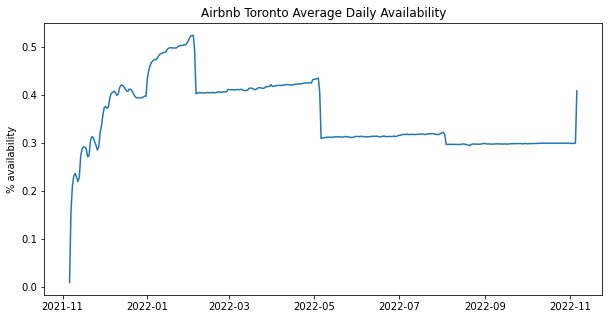

In [5]:
# take 'date', 'available' columns
monthly_avail = calendar_df.copy()[['date', 'available']]

# convert date column to datetime data type
monthly_avail['date'] = pd.to_datetime(monthly_avail['date'])

# function to convert t/f to 1/0
conv_func = lambda x: 1 if x == 't' else 0

# 0 = 'not available', 1 = 'available'
monthly_avail['availability'] = monthly_avail['available'].apply(conv_func)

# get the average daily availability
monthly_avail = monthly_avail.groupby('date')['availability'].mean().reset_index()

plt.figure(figsize=(10, 5))
plt.plot(monthly_avail['date'], monthly_avail['availability'])
plt.title('Airbnb Toronto Average Daily Availability')
plt.ylabel('% availability')
plt.show();

Looking at the graph, peak availability is observed in winter months especially in January and February. In contrast, summer and fall months seems much more busier as expected. 

#### Lets look at the price seasonality for the given period

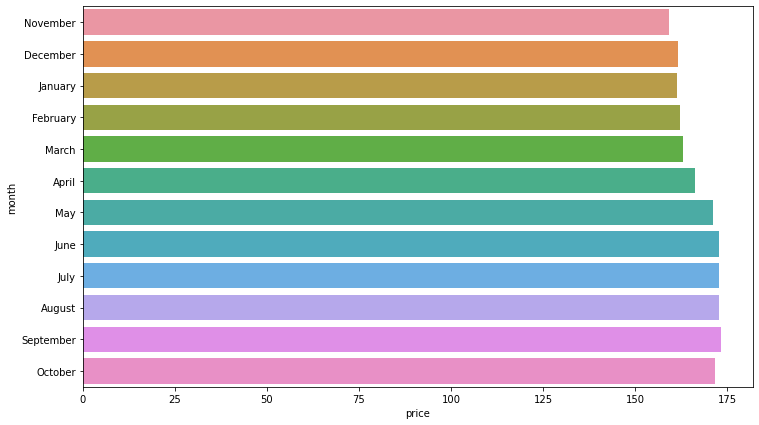

In [6]:
# take 'date', 'price' columns
calendar_price = calendar_df.copy()[['date', 'price']]
# convert date column to datetime data type
calendar_price['date'] = pd.to_datetime(calendar_price['date'])
# remove ',' and '$' signs and convert price data to float 
calendar_price['price'] = calendar_price['price'].str.replace(',', '', regex=True)
calendar_price['price'] = calendar_price['price'].str.replace('$', '', regex=True)
calendar_price['price'] = calendar_price['price'].astype(float)
# extract month name and add to a new column
calendar_price['month'] = calendar_price['date'].dt.month_name()

# take the average price for each month
mean_of_month = calendar_price.groupby('month', sort=False)['price'].mean().reset_index()

# plot the average price for each month
plt.rcParams['figure.figsize']=(12,7)
sns.barplot(x = "price", y = "month", data = mean_of_month)
plt.show();

We can observe higher average monthly prices for summer and fall months compared to winter and spring.

## Listing Data

In [32]:
# import listing data
listing_df = pd.read_csv('http://data.insideairbnb.com/canada/on/toronto/2021-11-06/data/listings.csv.gz')
# print number of rows and columns
print(listing_df.shape[0], listing_df.shape[1])
# look at the first 5 entries
listing_df.head()

15155 74


,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,1419,https://www.airbnb.com/rooms/1419,20211106153101,2021-11-07,Beautiful home in amazing area!,"This large, family home is located in one of T...",The apartment is located in the Ossington stri...,https://a0.muscache.com/pictures/76206750/d643...,1565,https://www.airbnb.com/users/show/1565,Alexandra,2008-08-08,"Vancouver, British Columbia, Canada","I live in Vancouver, Canada with my husband an...",NaN,NaN,NaN,f,https://a0.muscache.com/im/pictures/user/7aeea...,https://a0.muscache.com/im/pictures/user/7aeea...,Commercial Drive,1.0,1.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,"Toronto, Ontario, Canada",Little Portugal,NaN,43.64590,-79.42423,Entire residential home,Entire home/apt,10,NaN,3 baths,5.0,7.0,"[""Shampoo"", ""Smoke alarm"", ""Wifi"", ""Indoor fir...",$469.00,28,730,28,28,730,730,28.0,730.0,NaN,t,0,0,0,0,2021-11-07,7,0,0,2015-07-19,2017-12-04,5.00,5.00,5.00,5.00,5.00,5.00,5.00,NaN,f,1,1,0,0,0.09
1,8077,https://www.airbnb.com/rooms/8077,20211106153101,2021-11-07,Downtown Harbourfront Private Room,Guest room in a luxury condo with access to al...,NaN,https://a0.muscache.com/pictures/11780344/141c...,22795,https://www.airbnb.com/users/show/22795,Kathie & Larry,2009-06-22,"Toronto, Ontario, Canada",My husband and I have been airbnb host for alm...,NaN,NaN,NaN,f,https://a0.muscache.com/im/pictures/user/9a077...,https://a0.muscache.com/im/pictures/user/9a077...,Harbourfront,2.0,2.0,"['email', 'phone', 'facebook', 'reviews']",t,f,NaN,Waterfront Communities-The Island,NaN,43.64080,-79.37673,Private room in rental unit,Private room,2,NaN,1.5 baths,1.0,1.0,"[""Shampoo"", ""Free parking on premises"", ""Smoke...",$93.00,180,365,180,180,365,365,180.0,365.0,NaN,t,30,60,90,365,2021-11-07,169,0,0,2012-09-05,2013-08-27,4.84,4.81,4.89,4.87,4.90,4.92,4.83,NaN,t,2,1,1,0,1.51
2,23691,https://www.airbnb.com/rooms/23691,20211106153101,2021-11-07,Queen Bedroom close to downtown,<b>The space</b><br />Nestled in the middle of...,NaN,https://a0.muscache.com/pictures/615528/d09ab3...,93825,https://www.airbnb.com/users/show/93825,Yohan & Sarah,2010-03-15,"Toronto, Ontario, Canada",Welcome to our dwelling place! My wife and I l...,NaN,NaN,NaN,f,https://a0.muscache.com/im/users/93825/profile...,https://a0.muscache.com/im/users/93825/profile...,Fairbank,2.0,2.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,NaN,Briar Hill-Belgravia,NaN,43.69805,-79.45411,Private room in residential home,Private room,3,NaN,1 shared bath,1.0,1.0,"[""Refrigerator"", ""Dishes and silverware"", ""Han...",$72.00,28,28,28,28,28,28,28.0,28.0,NaN,t,30,60,90,365,2021-11-07,217,0,0,2011-08-22,2018-10-10,4.75,4.73,4.82,4.90,4.93,4.34,4.73,NaN,t,2,0,2,0,1.74


## Data Pre-processing

Lets narrow down the number of the columns to features that are useful for our analysis. Just by looking at the column names and explanations the following columns are selected.

In [33]:
selected_colummns = ['host_listings_count', 'neighbourhood_cleansed', 'room_type', 'accommodates', 'bathrooms_text', 
 'bedrooms', 'number_of_reviews', 'amenities', 'price']
listing_df = listing_df[selected_colummns]
print(listing_df.shape[0], listing_df.shape[1])
listing_df.head()

15155 9


,host_listings_count,neighbourhood_cleansed,room_type,accommodates,bathrooms_text,bedrooms,number_of_reviews,amenities,price
0,1.0,Little Portugal,Entire home/apt,10,3 baths,5.0,7,"[""Shampoo"", ""Smoke alarm"", ""Wifi"", ""Indoor fir...",$469.00
1,2.0,Waterfront Communities-The Island,Private room,2,1.5 baths,1.0,169,"[""Shampoo"", ""Free parking on premises"", ""Smoke...",$93.00
2,2.0,Briar Hill-Belgravia,Private room,3,1 shared bath,1.0,217,"[""Refrigerator"", ""Dishes and silverware"", ""Han...",$72.00
3,1.0,South Riverdale,Entire home/apt,1,1 bath,NaN,26,"[""Refrigerator"", ""Toaster"", ""BBQ grill"", ""Dish...",$45.00
4,2.0,Waterfront Communities-The Island,Entire home/apt,2,1.5 baths,1.0,1,"[""Free parking on premises"", ""Smoke alarm"", ""W...",$125.00


In [34]:
# percent of missing values in each column
perc_missing = listing_df.isnull().sum() * 100 / len(listing_df)
miss_val_listing = pd.DataFrame({'column_name': listing_df.columns, 'percent_missing': perc_missing}).reset_index(drop=True)
# look at the top 10 columns
miss_val_listing.sort_values('percent_missing', ascending=False)

,column_name,percent_missing
5,bedrooms,7.469482
4,bathrooms_text,0.085780
0,host_listings_count,0.079182
1,neighbourhood_cleansed,0.000000
2,room_type,0.000000
3,accommodates,0.000000
6,number_of_reviews,0.000000
7,amenities,0.000000
8,price,0.000000


Only **bedrooms** column has about 7.5% missing values

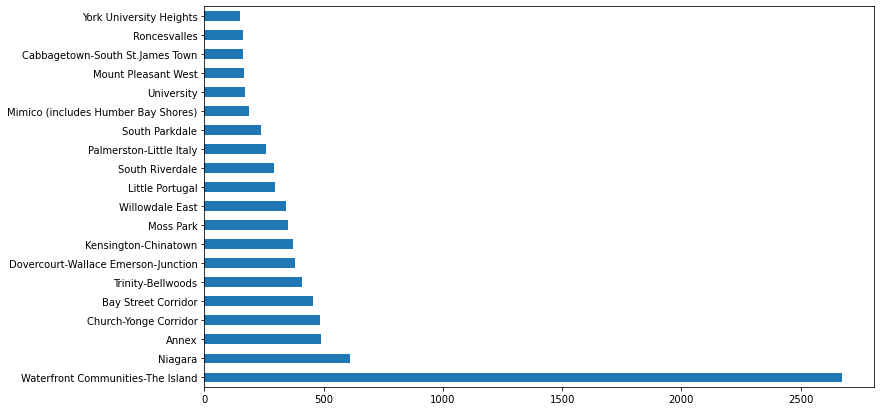

In [35]:
# looking at the top 20 neighborhood by numebr of listings
listing_df['neighbourhood_cleansed'].value_counts().head(20).plot(kind='barh');

One thing stand out from this barplot that **Waterfront Communities-The Island** neighborhood has the most listings in Toronto. Also, almost all of these neighborhoods are considered as the downtown of Toronto.

#### Lets see what is the most rented room type in Airbnb in Toronto.

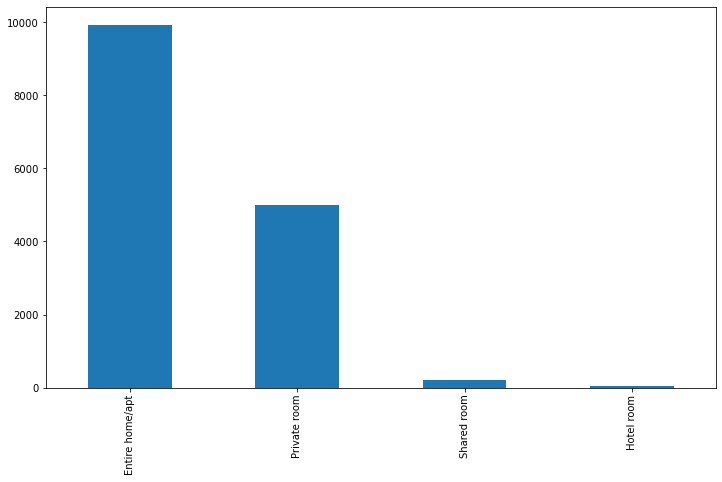

In [36]:
# looking at the top 20 neighborhood by numebr of listings
listing_df['room_type'].value_counts().head(20).plot(kind='bar');

Clearly most of the Airbnb customers prefer to rent the entire unit.

In [37]:
# lets look at the amenities column values
listing_df['amenities'].value_counts().head()

["Shampoo", "Smoke alarm", "Carbon monoxide alarm", "Wifi", "Air conditioning", "Long term stays allowed", "Washer", "Hangers", "Cooking basics", "Kitchen", "Elevator", "Gym", "Iron", "Heating", "TV", "Hair dryer", "Essentials", "Dedicated workspace", "Dryer"]                                        50
["Long term stays allowed"]                                                                                                                                                                                                                                                                                 47
["Shampoo", "Free parking on premises", "Smoke alarm", "Carbon monoxide alarm", "Wifi", "Air conditioning", "Long term stays allowed", "Washer", "First aid kit", "Hangers", "Fire extinguisher", "Kitchen", "Iron", "Heating", "Hot water", "Hair dryer", "Essentials", "Dedicated workspace", "Dryer"]    27
["Shampoo", "Smoke alarm", "Carbon monoxide alarm", "Wifi", "Air conditioning", "Long term 

Looking at the amenities column we can see that it is in a format that is not suitable for analysis currently. Each cell has a list of values which can be potentially be a variable that has an impact on the price. Lets take a few essential amenities and create a new column for each one. 

In [38]:
selected_amenities = ["Wifi", "Air conditioning", "Kitchen", "Heating", "Free parking on premises", "TV", 
                      "Washer", "Dryer", "Oven"]

# 1 if amenity exists, 0 if amenity doesn't exists
for val in selected_amenities:
    val_exists = []
    for i in range(len(listing_df)):
        if val in listing_df['amenities'][i]:
            val_exists.append(1)
        else:
            val_exists.append(0)
    listing_df[val] = val_exists

listing_df.head()   

,host_listings_count,neighbourhood_cleansed,room_type,accommodates,bathrooms_text,bedrooms,number_of_reviews,amenities,price,Wifi,Air conditioning,Kitchen,Heating,Free parking on premises,TV,Washer,Dryer,Oven
0,1.0,Little Portugal,Entire home/apt,10,3 baths,5.0,7,"[""Shampoo"", ""Smoke alarm"", ""Wifi"", ""Indoor fir...",$469.00,1,1,1,1,0,1,1,1,0
1,2.0,Waterfront Communities-The Island,Private room,2,1.5 baths,1.0,169,"[""Shampoo"", ""Free parking on premises"", ""Smoke...",$93.00,1,1,0,1,1,1,0,0,0
2,2.0,Briar Hill-Belgravia,Private room,3,1 shared bath,1.0,217,"[""Refrigerator"", ""Dishes and silverware"", ""Han...",$72.00,1,1,1,1,1,0,1,1,1
3,1.0,South Riverdale,Entire home/apt,1,1 bath,NaN,26,"[""Refrigerator"", ""Toaster"", ""BBQ grill"", ""Dish...",$45.00,1,1,1,1,0,1,1,1,1
4,2.0,Waterfront Communities-The Island,Entire home/apt,2,1.5 baths,1.0,1,"[""Free parking on premises"", ""Smoke alarm"", ""W...",$125.00,1,1,1,1,1,1,0,0,0


Now lets look at the numeric data columns

In [39]:
# remove ',' and '$' signs and convert price data to float 
listing_df['price'] = listing_df['price'].str.replace(',', '', regex=True)
listing_df['price'] = listing_df['price'].str.replace('$', '', regex=True)
listing_df['price'] = listing_df['price'].astype(float)

In [40]:
listing_numeric = listing_df.select_dtypes(include=['int', 'float'])
listing_numeric.head()

,host_listings_count,accommodates,bedrooms,number_of_reviews,price,Wifi,Air conditioning,Kitchen,Heating,Free parking on premises,TV,Washer,Dryer,Oven
0,1.0,10,5.0,7,469.0,1,1,1,1,0,1,1,1,0
1,2.0,2,1.0,169,93.0,1,1,0,1,1,1,0,0,0
2,2.0,3,1.0,217,72.0,1,1,1,1,1,0,1,1,1
3,1.0,1,NaN,26,45.0,1,1,1,1,0,1,1,1,1
4,2.0,2,1.0,1,125.0,1,1,1,1,1,1,0,0,0


#### Lets look at the correlation between price and other variables

In [41]:
# get the correlation between variables
listing_corr = listing_numeric.corr()
listing_corr

,host_listings_count,accommodates,bedrooms,number_of_reviews,price,Wifi,Air conditioning,Kitchen,Heating,Free parking on premises,TV,Washer,Dryer,Oven
host_listings_count,1.000000,0.043316,-0.007540,-0.039384,0.011829,0.027821,0.024185,0.030259,0.049389,-0.067033,0.046908,0.066662,0.078096,0.103714
accommodates,0.043316,1.000000,0.770439,0.060295,0.211717,0.023188,0.075750,0.104180,-0.000713,0.189374,0.273204,0.112702,0.111522,0.157138
bedrooms,-0.007540,0.770439,1.000000,-0.031318,0.199321,0.011857,0.064482,0.097446,0.006495,0.203891,0.180726,0.106613,0.101034,0.071575
number_of_reviews,-0.039384,0.060295,-0.031318,1.000000,-0.018037,0.036065,0.016531,-0.080089,0.053951,-0.001258,0.082288,-0.051841,-0.023190,0.176183
price,0.011829,0.211717,0.199321,-0.018037,1.000000,-0.013196,0.042835,0.013828,0.002892,0.031340,0.084000,0.049607,0.047010,0.005836
Wifi,0.027821,0.023188,0.011857,0.036065,-0.013196,1.000000,0.114970,0.090216,0.146469,0.040743,0.087750,0.090848,0.079473,0.069176
Air conditioning,0.024185,0.075750,0.064482,0.016531,0.042835,0.114970,1.000000,0.025642,0.354369,0.136763,0.118365,0.260748,0.246441,0.020892
Kitchen,0.030259,0.104180,0.097446,-0.080089,0.013828,0.090216,0.025642,1.000000,0.023834,0.019318,0.129540,0.231428,0.208827,0.240791
Heating,0.049389,-0.000713,0.006495,0.053951,0.002892,0.146469,0.354369,0.023834,1.000000,0.065441,0.015251,0.260368,0.387688,0.057835
Free parking on premises,-0.067033,0.189374,0.203891,-0.001258,0.031340,0.040743,0.136763,0.019318,0.065441,1.000000,0.069885,0.134607,0.114628,0.002144


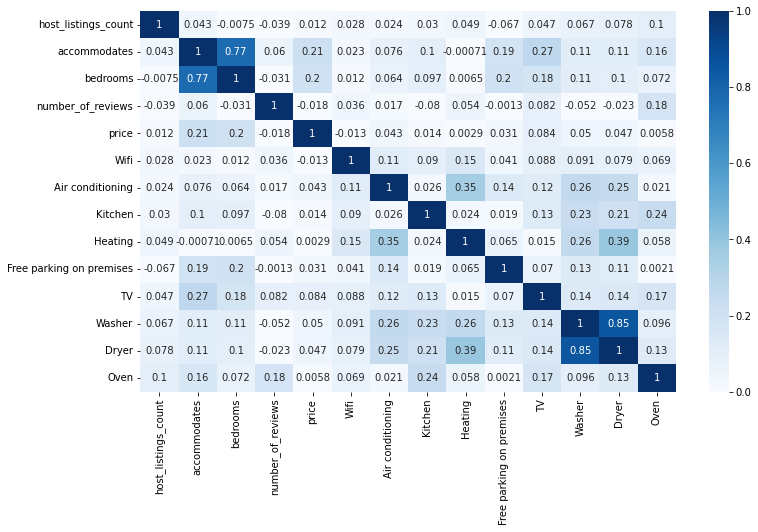

In [42]:
# plot a heatmap of the correlations
sns.heatmap(listing_corr, cmap = 'Blues', xticklabels=True, yticklabels=True, vmin=0, vmax=1, annot=True);

Looking at the heatmap we can conclude that **accomodates** and **bedrooms** variables have higher correlations with **price** than other variables. Since **accomodates** column means number of people can live in the unit it makes sense that it will be positively correlated with the **price**. Besides, more **bedrooms** means more people can stay in the unit, which again explains the correlation with the **price**.